In [169]:

import matplotlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [181]:
game_labels = set(["cricket", "hockey", "chess"])

In [148]:
game_labels

{'chess', 'cricket', 'hockey'}

In [182]:
location = "/Users/vaibhavverdhan/BackupOfOfficeMac/Book/Restart/Apress/Chapter7/Sports-Type-Classifier-master/data"

In [183]:
data_path = list(paths.list_images(location))

In [184]:
complete_data = []
complete_labels = []

In [88]:
type(data_path)

list

In [89]:
for data in data_path:
    # extract the class label from the filename
    class_label = data.split("/")[-2]
    if class_label not in game_labels:
        #print("Not used class lable",class_label)
        continue
    #print("Used class lable",class_label)
    image = cv2.imread(data)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    
    complete_data.append(image)
    complete_labels.append(class_label)

In [90]:
len(complete_data)

1710

In [91]:
len(complete_labels)

1710

In [92]:
# convert the complete_data, complete_labels to NumPy arrays
complete_data = np.array(complete_data)
complete_labels = np.array(complete_labels)


In [93]:
#  one-hot encoding on the labels
label_binarizer = LabelBinarizer()
complete_labels = label_binarizer.fit_transform(complete_labels)


In [94]:
#divide into 80% train and 20% split
(x_train, x_test, y_train, y_test) = train_test_split(complete_data, complete_labels,
    test_size=0.20, stratify=complete_labels, random_state=5)

In [95]:
x_train.shape

(1368, 299, 299, 3)

In [96]:
x_test.shape

(342, 299, 299, 3)

In [97]:
y_train.shape

(1368, 3)

In [98]:
y_test.shape

(342, 3)

In [99]:
# initialize the data augmentation object for the training data
training_augumentation = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.12,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.10,
    horizontal_flip=True,
    fill_mode="nearest")


In [108]:
validation_augumentation = ImageDataGenerator()

mean = np.array([122.6, 115.5, 105.9], dtype="float32")
training_augumentation.mean = mean
validation_augumentation.mean = mean

In [109]:
# load the Inceptionv3 network

inceptionModel = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(299, 299, 3)))


In [110]:

outModel = inceptionModel.output
outModel = AveragePooling2D(pool_size=(5, 5))(outModel)
outModel = Flatten(name="flatten")(outModel)
outModel = Dense(512, activation="relu")(outModel)
outModel = Dropout(0.6)(outModel)
outModel = Dense(len(label_binarizer.classes_), activation="softmax")(outModel)


In [111]:

final_model = Model(inputs=inceptionModel.input, outputs=outModel)
for layer in inceptionModel.layers:
    layer.trainable = False

In [138]:
num_epochs = 5
learning_rate = 0.1
learning_decay = 1e-6
learning_drop = 20
batch_size = 32

In [133]:
sgd = optimizers.SGD(lr=learning_rate, decay=learning_decay, momentum=0.9, nesterov=True)
final_model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [139]:
model_fit = final_model.fit(
    x=training_augumentation.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=validation_augumentation.flow(x_test, y_test),
    validation_steps=len(x_test) // batch_size,
    epochs=num_epochs)

Epoch 1/5
43/43 [==============================] - 217s 5s/step - loss: 10.7571 - acc: 0.3326 - val_loss: 10.7731 - val_acc: 0.3333
Epoch 2/5
43/43 [==============================] - 208s 5s/step - loss: 10.7571 - acc: 0.3326 - val_loss: 10.6691 - val_acc: 0.3333
Epoch 3/5
43/43 [==============================] - 195s 5s/step - loss: 10.7457 - acc: 0.3326 - val_loss: 10.7940 - val_acc: 0.3333
Epoch 4/5
43/43 [==============================] - 195s 5s/step - loss: 10.7187 - acc: 0.3333 - val_loss: 10.7315 - val_acc: 0.3333
Epoch 5/5
43/43 [==============================] - 201s 5s/step - loss: 10.7189 - acc: 0.3333 - val_loss: 10.7315 - val_acc: 0.3333


In [140]:
model_fit.history

{'loss': [10.757179254676863,
  10.757179176598264,
  10.757179176598264,
  10.745396767443383,
  10.734147501270673],
 'acc': [0.33260235, 0.33260235, 0.33260235, 0.33333334, 0.33333334],
 'val_loss': [10.773148449984463,
  10.669080127369273,
  10.79396204514937,
  10.731521086259322,
  10.731521172956986],
 'val_acc': [0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.33333334]}

Text(0, 0.5, 'acc')

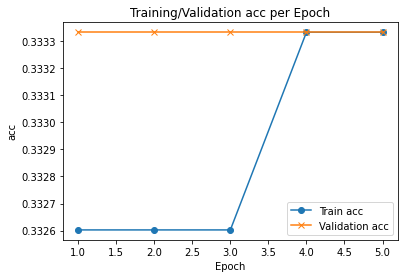

In [141]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + model_fit.history['acc'], 'o-')
ax.plot([None] + model_fit.history['val_acc'], 'x-')
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

Text(0, 0.5, 'Loss')

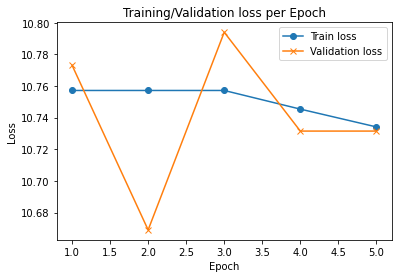

In [142]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + model_fit.history['loss'], 'o-')
ax.plot([None] + model_fit.history['val_loss'], 'x-')
ax.legend(['Train loss', 'Validation loss'], loc = 0)
ax.set_title('Training/Validation loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [143]:
predictions = model_fit.model.predict(testX)

In [144]:
from sklearn.metrics import confusion_matrix
import numpy as np

rounded_labels=np.argmax(testY, axis=1)
rounded_labels[1]

0

In [145]:
cm = confusion_matrix(rounded_labels, np.argmax(predictions,axis=1))

In [146]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()

/Users/vaibhavverdhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


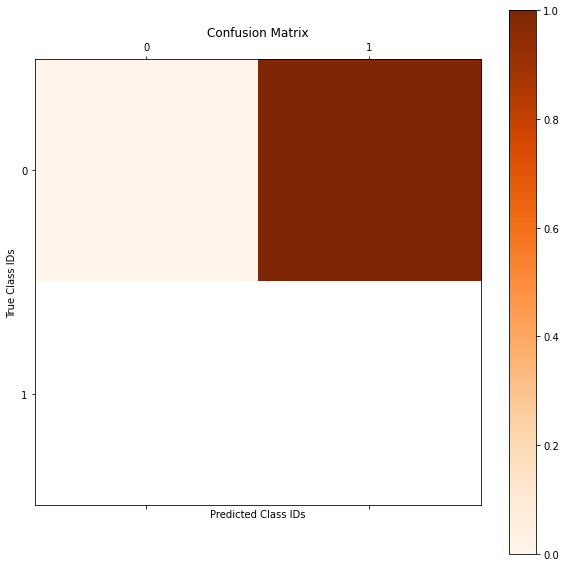

In [147]:
plot_confusion_matrix(cm)

              precision    recall  f1-score   support

       chess       0.00      0.00      0.00        95
     cricket       0.00      0.00      0.00       133
      hockey       0.33      1.00      0.50       114

   micro avg       0.33      0.33      0.33       342
   macro avg       0.11      0.33      0.17       342
weighted avg       0.11      0.33      0.17       342



/Users/vaibhavverdhan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


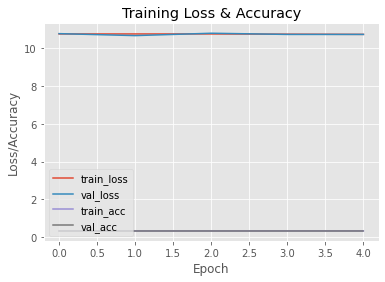

In [153]:
model_predictions = model_fit.model.predict(x=x_test.astype("float32"), batch_size=32)
print(classification_report(y_test.argmax(axis=1),
    predictions.argmax(axis=1), target_names=label_binarizer.classes_))
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model_fit.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), model_fit.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), model_fit.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), model_fit.history["val_acc"], label="val_acc")
plt.title("Training Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [255]:
import numpy as np
import cv2

In [256]:
path_video = "/Users/vaibhavverdhan/BackupOfOfficeMac/Book/Restart/Apress/Chapter7/cricket.mp4"

In [168]:
video = cv2.VideoCapture(path_video)
video_writer = None
(width, height) = (None, None)

while True:
    (isVideoGrabbed, video_frame) = video.read()
    #print(isVideoGrabbed)
    if not isVideoGrabbed:
        break
    # if the frame dimensions are empty, grab them
    #if width is None or height is None:
    else:
        (height, width) = video_frame.shape[:2]
        print("Height of the frame:",height)
        print("Width of the frame:",width)
        video_frame = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)
        video_frame = cv2.resize(video_frame, (299, 299)).astype("float32")
        video_frame -= mean
        #prediction_game = model_fit.model.predict(np.expand_dims(video_frame, axis=0))[0]
        #print(prediction_game)
        #(width, height) = (None, None)

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame: 360
Width of the frame: 640
Height of the frame:

# ResNet Implementation

In [190]:
from tensorflow.keras.applications import ResNet50

In [214]:
game_labels = set(["cricket", "swimming", "wrestling"])
data_path = list(paths.list_images(location))
complete_data = []
complete_labels = []

In [215]:
for data in data_path:
    # extract the class label from the filename
    class_label = data.split("/")[-2]
    if class_label not in game_labels:
        #print("Not used class lable",class_label)
        continue
    #print("Used class lable",class_label)
    image = cv2.imread(data)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    complete_data.append(image)
    complete_labels.append(class_label)

In [216]:
# convert the complete_data, complete_labels to NumPy arrays
complete_data = np.array(complete_data)
complete_labels = np.array(complete_labels)


In [217]:
#  one-hot encoding on the labels
label_binarizer = LabelBinarizer()
complete_labels = label_binarizer.fit_transform(complete_labels)


In [218]:
#divide into 70% train and 30% split
(x_train, x_test, y_train, y_test) = train_test_split(complete_data, complete_labels,
    test_size=0.30, stratify=complete_labels, random_state=5)

In [219]:
# initialize the data augmentation object for the training data
training_augumentation = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.12,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.10,
    horizontal_flip=True,
    fill_mode="nearest")


In [220]:
validation_augumentation = ImageDataGenerator()

mean = np.array([122.6, 115.5, 105.9], dtype="float32")
training_augumentation.mean = mean
validation_augumentation.mean = mean

In [221]:
# load the ResNet network

resNet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


/Users/vaibhavverdhan/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [222]:

outModel = resNet.output
outModel = AveragePooling2D(pool_size=(5, 5))(outModel)
outModel = Flatten(name="flatten")(outModel)
outModel = Dense(512, activation="relu")(outModel)
outModel = Dropout(0.5)(outModel)
outModel = Dense(len(label_binarizer.classes_), activation="softmax")(outModel)


In [223]:

final_model = Model(inputs=resNet.input, outputs=outModel)
for layer in inceptionModel.layers:
    layer.trainable = False

In [224]:
num_epochs = 5
learning_rate = 0.05
learning_decay = 1e-5
learning_drop = 15
batch_size = 16

In [225]:
sgd = optimizers.SGD(lr=learning_rate, decay=learning_decay, momentum=0.6, nesterov=True)
final_model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [226]:
model_fit = final_model.fit(
    x=training_augumentation.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=validation_augumentation.flow(x_test, y_test),
    validation_steps=len(x_test) // batch_size,
    epochs=num_epochs)

Epoch 1/5
86/86 [==============================] - 619s 7s/step - loss: 1.1110 - acc: 0.6122 - val_loss: 7.8011 - val_acc: 0.3077
Epoch 2/5
86/86 [==============================] - 914s 11s/step - loss: 0.6576 - acc: 0.7295 - val_loss: 0.8106 - val_acc: 0.7316
Epoch 3/5
86/86 [==============================] - 601s 7s/step - loss: 0.5137 - acc: 0.7999 - val_loss: 0.7306 - val_acc: 0.7692
Epoch 4/5
86/86 [==============================] - 736s 9s/step - loss: 0.4913 - acc: 0.8087 - val_loss: 0.6629 - val_acc: 0.7248
Epoch 5/5
86/86 [==============================] - 624s 7s/step - loss: 0.4151 - acc: 0.8482 - val_loss: 0.4514 - val_acc: 0.8581


Text(0, 0.5, 'acc')

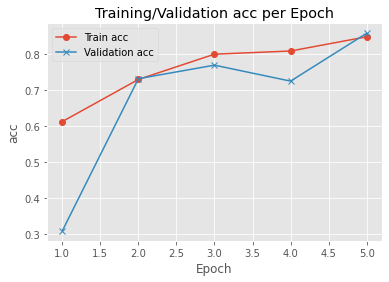

In [227]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + model_fit.history['acc'], 'o-')
ax.plot([None] + model_fit.history['val_acc'], 'x-')
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

Text(0, 0.5, 'Loss')

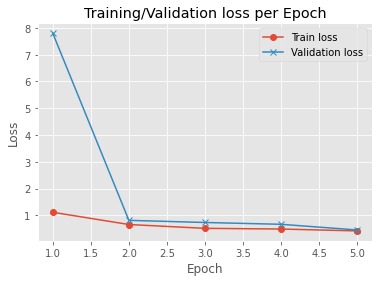

In [228]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([None] + model_fit.history['loss'], 'o-')
ax.plot([None] + model_fit.history['val_loss'], 'x-')
ax.legend(['Train loss', 'Validation loss'], loc = 0)
ax.set_title('Training/Validation loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [230]:
predictions = model_fit.model.predict(x_test)

In [231]:
from sklearn.metrics import confusion_matrix
import numpy as np

rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

2

In [232]:
cm = confusion_matrix(rounded_labels, np.argmax(predictions,axis=1))

In [233]:
def plot_confusion_matrix(cm):
    cm = [row/sum(row)   for row in cm]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()

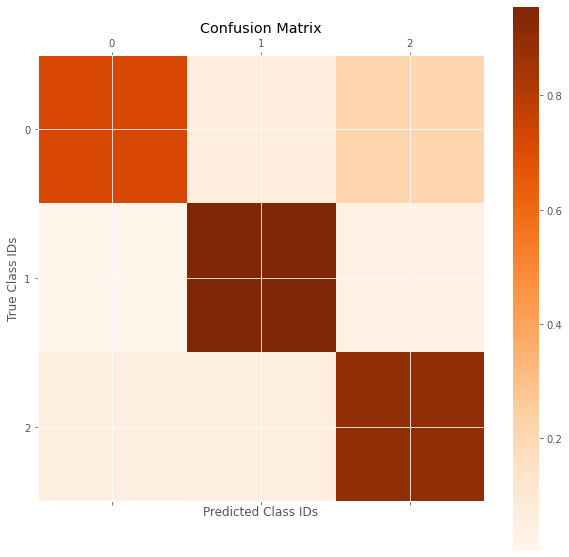

In [234]:
plot_confusion_matrix(cm)

              precision    recall  f1-score   support

     cricket       0.94      0.72      0.82       200
    swimming       0.89      0.96      0.92       205
   wrestling       0.76      0.89      0.82       180

   micro avg       0.86      0.86      0.86       585
   macro avg       0.86      0.86      0.85       585
weighted avg       0.87      0.86      0.86       585



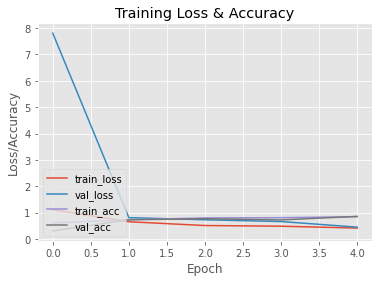

In [235]:
model_predictions = model_fit.model.predict(x=x_test.astype("float32"), batch_size=32)
print(classification_report(y_test.argmax(axis=1),
    predictions.argmax(axis=1), target_names=label_binarizer.classes_))
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model_fit.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), model_fit.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), model_fit.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), model_fit.history["val_acc"], label="val_acc")
plt.title("Training Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [244]:
model_fit.model.save("sport_classification_model.h5")

# Use the model for predictions

In [268]:
from tensorflow.keras.models import load_model 


In [269]:
file = open("sport_classification", "wb")
file.write(pickle.dumps(label_binarizer))
file.close()

In [270]:
modelToBeUsed = load_model("sport_classification_model.h5")


In [271]:
labels = pickle.loads(open("sport_classification", "rb").read())

In [263]:
import numpy as np
from keras.preprocessing import image
an_image =image.load_img('/Users/vaibhavverdhan/BackupOfOfficeMac/Book/Restart/Apress/Chapter7/Sports-Type-Classifier-master/data/cricket/00000000.jpg',target_size =(224,224))# Load the image
# The image is now getting converted to array of numbers
an_image =image.img_to_array(an_image)
#Let us now expand it's dimensions. It will improve the prediction power 
an_image =np.expand_dims(an_image, axis =0)
# call the predict method here
verdict = modelToBeUsed.predict(an_image)

In [251]:
verdict

array([[0.92556924, 0.01020071, 0.06423005]], dtype=float32)

In [253]:
i = np.argmax(verdict)
label = labels.classes_[i]

In [254]:
label

'cricket'

In [280]:
video = cv2.VideoCapture(path_video)

isVideoGrabbed = 1
count = 0
while isVideoGrabbed:
    (isVideoGrabbed, video_frame) = video.read()
    
    if not isVideoGrabbed:
        print("done")
        break
    count = count +1
    #print(count)
    video_frame = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)
    video_frame = cv2.resize(video_frame, (224, 224)).astype("float32")
    video_frame -= mean
    prediction_game = modelToBeUsed.predict(np.expand_dims(video_frame, axis=0))[0]
    i = np.argmax(verdict)
    game = labels.classes_[i]
    #print(game)

1
cricket
2
cricket
3
cricket
4
cricket
5
cricket
6
cricket
7
cricket
8
cricket
9
cricket
10
cricket
11
cricket
12
cricket
13
cricket
14
cricket
15
cricket
16
cricket
17
cricket
18
cricket
19
cricket
20
cricket
21
cricket
22
cricket
23
cricket
24
cricket
25
cricket
26
cricket
27
cricket
28
cricket
29
cricket
30
cricket
31
cricket
32
cricket
33
cricket
34
cricket
35
cricket
36
cricket
37
cricket
38
cricket
39
cricket
40
cricket
41
cricket
42
cricket
43
cricket
44
cricket
45
cricket
46
cricket
47
cricket
48
cricket
49
cricket
50
cricket
51
cricket
52
cricket
53
cricket
54
cricket
55
cricket
56
cricket
57
cricket
58
cricket
59
cricket
60
cricket
61
cricket
62
cricket
63
cricket
64
cricket
65
cricket
66
cricket
67
cricket
68
cricket
69
cricket
70
cricket
71
cricket
72
cricket
73
cricket
74
cricket
75
cricket
76
cricket
77
cricket
78
cricket
79
cricket
80
cricket
81
cricket
82
cricket
83
cricket
84
cricket
85
cricket
86
cricket
87
cricket
88
cricket
89
cricket
90
cricket
91
cricket
92
crick

cricket
694
cricket
695
cricket
696
cricket
697
cricket
698
cricket
699
cricket
700
cricket
701
cricket
702
cricket
703
cricket
704
cricket
705
cricket
706
cricket
707
cricket
708
cricket
709
cricket
710
cricket
711
cricket
712
cricket
713
cricket
714
cricket
715
cricket
716
cricket
717
cricket
718
cricket
719
cricket
720
cricket
721
cricket
722
cricket
723
cricket
724
cricket
725
cricket
726
cricket
727
cricket
728
cricket
729
cricket
730
cricket
731
cricket
732
cricket
733
cricket
734
cricket
735
cricket
736
cricket
737
cricket
738
cricket
739
cricket
740
cricket
741
cricket
742
cricket
743
cricket
744
cricket
745
cricket
746
cricket
747
cricket
748
cricket
749
cricket
750
cricket
751
cricket
752
cricket
753
cricket
754
cricket
755
cricket
756
cricket
757
cricket
758
cricket
759
cricket
760
cricket
761
cricket
762
cricket
763
cricket
764
cricket
765
cricket
766
cricket
767
cricket
768
cricket
769
cricket
770
cricket
771
cricket
772
cricket
773
cricket
774
cricket
775
cricket
776
cric

cricket
1349
cricket
1350
cricket
1351
cricket
1352
cricket
1353
cricket
1354
cricket
1355
cricket
1356
cricket
1357
cricket
1358
cricket
1359
cricket
1360
cricket
1361
cricket
1362
cricket
1363
cricket
1364
cricket
1365
cricket
1366
cricket
1367
cricket
1368
cricket
1369
cricket
1370
cricket
1371
cricket
1372
cricket
1373
cricket
1374
cricket
1375
cricket
1376
cricket
1377
cricket
1378
cricket
1379
cricket
1380
cricket
1381
cricket
1382
cricket
1383
cricket
1384
cricket
1385
cricket
1386
cricket
1387
cricket
1388
cricket
1389
cricket
1390
cricket
1391
cricket
1392
cricket
1393
cricket
1394
cricket
1395
cricket
1396
cricket
1397
cricket
1398
cricket
1399
cricket
1400
cricket
1401
cricket
1402
cricket
1403
cricket
1404
cricket
1405
cricket
1406
cricket
1407
cricket
1408
cricket
1409
cricket
1410
cricket
1411
cricket
1412
cricket
1413
cricket
1414
cricket
1415
cricket
1416
cricket
1417
cricket
1418
cricket
1419
cricket
1420
cricket
1421
cricket
1422
cricket
1423
cricket
1424
cricket
1425

cricket
1980
cricket
1981
cricket
1982
cricket
1983
cricket
1984
cricket
1985
cricket
1986
cricket
1987
cricket
1988
cricket
1989
cricket
1990
cricket
1991
cricket
1992
cricket
1993
cricket
1994
cricket
1995
cricket
1996
cricket
1997
cricket
1998
cricket
1999
cricket
2000
cricket
2001
cricket
2002
cricket
2003
cricket
2004
cricket
2005
cricket
2006
cricket
2007
cricket
2008
cricket
2009
cricket
2010
cricket
2011
cricket
2012
cricket
2013
cricket
2014
cricket
2015
cricket
2016
cricket
2017
cricket
2018
cricket
2019
cricket
2020
cricket
2021
cricket
2022
cricket
2023
cricket
2024
cricket
2025
cricket
2026
cricket
2027
cricket
2028
cricket
2029
cricket
2030
cricket
2031
cricket
2032
cricket
2033
cricket
2034
cricket
2035
cricket
2036
cricket
2037
cricket
2038
cricket
2039
cricket
2040
cricket
2041
cricket
2042
cricket
2043
cricket
2044
cricket
2045
cricket
2046
cricket
2047
cricket
2048
cricket
2049
cricket
2050
cricket
2051
cricket
2052
cricket
2053
cricket
2054
cricket
2055
cricket
2056

cricket
2612
cricket
2613
cricket
2614
cricket
2615
cricket
2616
cricket
2617
cricket
2618
cricket
2619
cricket
2620
cricket
2621
cricket
2622
cricket
2623
cricket
2624
cricket
2625
cricket
2626
cricket
2627
cricket
2628
cricket
2629
cricket
2630
cricket
2631
cricket
2632
cricket
2633
cricket
2634
cricket
2635
cricket
2636
cricket
2637
cricket
2638
cricket
2639
cricket
2640
cricket
2641
cricket
2642
cricket
2643
cricket
2644
cricket
2645
cricket
2646
cricket
2647
cricket
2648
cricket
2649
cricket
2650
cricket
2651
cricket
2652
cricket
2653
cricket
2654
cricket
2655
cricket
2656
cricket
2657
cricket
2658
cricket
2659
cricket
2660
cricket
2661
cricket
2662
cricket
2663
cricket
2664
cricket
2665
cricket
2666
cricket
2667
cricket
2668
cricket
2669
cricket
2670
cricket
2671
cricket
2672
cricket
2673
cricket
2674
cricket
2675
cricket
2676
cricket
2677
cricket
2678
cricket
2679
cricket
2680
cricket
2681
cricket
2682
cricket
2683
cricket
2684
cricket
2685
cricket
2686
cricket
2687
cricket
2688

cricket
3243
cricket
3244
cricket
3245
cricket
3246
cricket
3247
cricket
3248
cricket
3249
cricket
3250
cricket
3251
cricket
3252
cricket
3253
cricket
3254
cricket
3255
cricket
3256
cricket
3257
cricket
3258
cricket
3259
cricket
3260
cricket
3261
cricket
3262
cricket
3263
cricket
3264
cricket
3265
cricket
3266
cricket
3267
cricket
3268
cricket
3269
cricket
3270
cricket
3271
cricket
3272
cricket
3273
cricket
3274
cricket
3275
cricket
3276
cricket
3277
cricket
3278
cricket
3279
cricket
3280
cricket
3281
cricket
3282
cricket
3283
cricket
3284
cricket
3285
cricket
3286
cricket
3287
cricket
3288
cricket
3289
cricket
3290
cricket
3291
cricket
3292
cricket
3293
cricket
3294
cricket
3295
cricket
3296
cricket
3297
cricket
3298
cricket
3299
cricket
3300
cricket
3301
cricket
3302
cricket
3303
cricket
3304
cricket
3305
cricket
3306
cricket
3307
cricket
3308
cricket
3309
cricket
3310
cricket
3311
cricket
3312
cricket
3313
cricket
3314
cricket
3315
cricket
3316
cricket
3317
cricket
3318
cricket
3319

cricket
3875
cricket
3876
cricket
3877
cricket
3878
cricket
3879
cricket
3880
cricket
3881
cricket
3882
cricket
3883
cricket
3884
cricket
3885
cricket
3886
cricket
3887
cricket
3888
cricket
3889
cricket
3890
cricket
3891
cricket
3892
cricket
3893
cricket
3894
cricket
3895
cricket
3896
cricket
3897
cricket
3898
cricket
3899
cricket
3900
cricket
3901
cricket
3902
cricket
3903
cricket
3904
cricket
3905
cricket
3906
cricket
3907
cricket
3908
cricket
3909
cricket
3910
cricket
3911
cricket
3912
cricket
3913
cricket
3914
cricket
3915
cricket
3916
cricket
3917
cricket
3918
cricket
3919
cricket
3920
cricket
3921
cricket
3922
cricket
3923
cricket
3924
cricket
3925
cricket
3926
cricket
3927
cricket
3928
cricket
3929
cricket
3930
cricket
3931
cricket
3932
cricket
3933
cricket
3934
cricket
3935
cricket
3936
cricket
3937
cricket
3938
cricket
3939
cricket
3940
cricket
3941
cricket
3942
cricket
3943
cricket
3944
cricket
3945
cricket
3946
cricket
3947
cricket
3948
cricket
3949
cricket
3950
cricket
3951

cricket
4507
cricket
4508
cricket
4509
cricket
4510
cricket
4511
cricket
4512
cricket
4513
cricket
4514
cricket
4515
cricket
4516
cricket
4517
cricket
4518
cricket
4519
cricket
4520
cricket
4521
cricket
4522
cricket
4523
cricket
4524
cricket
4525
cricket
4526
cricket
4527
cricket
4528
cricket
4529
cricket
4530
cricket
4531
cricket
4532
cricket
4533
cricket
4534
cricket
4535
cricket
4536
cricket
4537
cricket
4538
cricket
4539
cricket
4540
cricket
4541
cricket
4542
cricket
4543
cricket
4544
cricket
4545
cricket
4546
cricket
4547
cricket
4548
cricket
4549
cricket
4550
cricket
4551
cricket
4552
cricket
4553
cricket
4554
cricket
4555
cricket
4556
cricket
4557
cricket
4558
cricket
4559
cricket
4560
cricket
4561
cricket
4562
cricket
4563
cricket
4564
cricket
4565
cricket
4566
cricket
4567
cricket
4568
cricket
4569
cricket
4570
cricket
4571
cricket
4572
cricket
4573
cricket
4574
cricket
4575
cricket
4576
cricket
4577
cricket
4578
cricket
4579
cricket
4580
cricket
4581
cricket
4582
cricket
4583

5139
cricket
5140
cricket
5141
cricket
5142
cricket
5143
cricket
5144
cricket
5145
cricket
5146
cricket
5147
cricket
5148
cricket
5149
cricket
5150
cricket
5151
cricket
5152
cricket
5153
cricket
5154
cricket
5155
cricket
5156
cricket
5157
cricket
5158
cricket
5159
cricket
5160
cricket
5161
cricket
5162
cricket
5163
cricket
5164
cricket
5165
cricket
5166
cricket
5167
cricket
5168
cricket
5169
cricket
5170
cricket
5171
cricket
5172
cricket
5173
cricket
5174
cricket
5175
cricket
5176
cricket
5177
cricket
5178
cricket
5179
cricket
5180
cricket
5181
cricket
5182
cricket
5183
cricket
5184
cricket
5185
cricket
5186
cricket
5187
cricket
5188
cricket
5189
cricket
5190
cricket
5191
cricket
5192
cricket
5193
cricket
5194
cricket
5195
cricket
5196
cricket
5197
cricket
5198
cricket
5199
cricket
5200
cricket
5201
cricket
5202
cricket
5203
cricket
5204
cricket
5205
cricket
5206
cricket
5207
cricket
5208
cricket
5209
cricket
5210
cricket
5211
cricket
5212
cricket
5213
cricket
5214
cricket
5215
cricket

cricket
5770
cricket
5771
cricket
5772
cricket
5773
cricket
5774
cricket
5775
cricket
5776
cricket
5777
cricket
5778
cricket
5779
cricket
5780
cricket
5781
cricket
5782
cricket
5783
cricket
5784
cricket
5785
cricket
5786
cricket
5787
cricket
5788
cricket
5789
cricket
5790
cricket
5791
cricket
5792
cricket
5793
cricket
5794
cricket
5795
cricket
5796
cricket
5797
cricket
5798
cricket
5799
cricket
5800
cricket
5801
cricket
5802
cricket
5803
cricket
5804
cricket
5805
cricket
5806
cricket
5807
cricket
5808
cricket
5809
cricket
5810
cricket
5811
cricket
5812
cricket
5813
cricket
5814
cricket
5815
cricket
5816
cricket
5817
cricket
5818
cricket
5819
cricket
5820
cricket
5821
cricket
5822
cricket
5823
cricket
5824
cricket
5825
cricket
5826
cricket
5827
cricket
5828
cricket
5829
cricket
5830
cricket
5831
cricket
5832
cricket
5833
cricket
5834
cricket
5835
cricket
5836
cricket
5837
cricket
5838
cricket
5839
cricket
5840
cricket
5841
cricket
5842
cricket
5843
cricket
5844
cricket
5845
cricket
5846

cricket
6401
cricket
6402
cricket
6403
cricket
6404
cricket
6405
cricket
6406
cricket
6407
cricket
6408
cricket
6409
cricket
6410
cricket
6411
cricket
6412
cricket
6413
cricket
6414
cricket
6415
cricket
6416
cricket
6417
cricket
6418
cricket
6419
cricket
6420
cricket
6421
cricket
6422
cricket
6423
cricket
6424
cricket
6425
cricket
6426
cricket
6427
cricket
6428
cricket
6429
cricket
6430
cricket
6431
cricket
6432
cricket
6433
cricket
6434
cricket
6435
cricket
6436
cricket
6437
cricket
6438
cricket
6439
cricket
6440
cricket
6441
cricket
6442
cricket
6443
cricket
6444
cricket
6445
cricket
6446
cricket
6447
cricket
6448
cricket
6449
cricket
6450
cricket
6451
cricket
6452
cricket
6453
cricket
6454
cricket
6455
cricket
6456
cricket
6457
cricket
6458
cricket
6459
cricket
6460
cricket
6461
cricket
6462
cricket
6463
cricket
6464
cricket
6465
cricket
6466
cricket
6467
cricket
6468
cricket
6469
cricket
6470
cricket
6471
cricket
6472
cricket
6473
cricket
6474
cricket
6475
cricket
6476
cricket
6477

cricket
7032
cricket
7033
cricket
7034
cricket
7035
cricket
7036
cricket
7037
cricket
7038
cricket
7039
cricket
7040
cricket
7041
cricket
7042
cricket
7043
cricket
7044
cricket
7045
cricket
7046
cricket
7047
cricket
7048
cricket
7049
cricket
7050
cricket
7051
cricket
7052
cricket
7053
cricket
7054
cricket
7055
cricket
7056
cricket
7057
cricket
7058
cricket
7059
cricket
7060
cricket
7061
cricket
7062
cricket
7063
cricket
7064
cricket
7065
cricket
7066
cricket
7067
cricket
7068
cricket
7069
cricket
7070
cricket
7071
cricket
7072
cricket
7073
cricket
7074
cricket
7075
cricket
7076
cricket
7077
cricket
7078
cricket
7079
cricket
7080
cricket
7081
cricket
7082
cricket
7083
cricket
7084
cricket
7085
cricket
7086
cricket
7087
cricket
7088
cricket
7089
cricket
7090
cricket
7091
cricket
7092
cricket
7093
cricket
7094
cricket
7095
cricket
7096
cricket
7097
cricket
7098
cricket
7099
cricket
7100
cricket
7101
cricket
7102
cricket
7103
cricket
7104
cricket
7105
cricket
7106
cricket
7107
cricket
7108

7664
cricket
7665
cricket
7666
cricket
7667
cricket
7668
cricket
7669
cricket
7670
cricket
7671
cricket
7672
cricket
7673
cricket
7674
cricket
7675
cricket
7676
cricket
7677
cricket
7678
cricket
7679
cricket
7680
cricket
7681
cricket
7682
cricket
7683
cricket
7684
cricket
7685
cricket
7686
cricket
7687
cricket
7688
cricket
7689
cricket
7690
cricket
7691
cricket
7692
cricket
7693
cricket
7694
cricket
7695
cricket
7696
cricket
7697
cricket
7698
cricket
7699
cricket
7700
cricket
7701
cricket
7702
cricket
7703
cricket
7704
cricket
7705
cricket
7706
cricket
7707
cricket
7708
cricket
7709
cricket
7710
cricket
7711
cricket
7712
cricket
7713
cricket
7714
cricket
7715
cricket
7716
cricket
7717
cricket
7718
cricket
7719
cricket
7720
cricket
7721
cricket
7722
cricket
7723
cricket
7724
cricket
7725
cricket
7726
cricket
7727
cricket
7728
cricket
7729
cricket
7730
cricket
7731
cricket
7732
cricket
7733
cricket
7734
cricket
7735
cricket
7736
cricket
7737
cricket
7738
cricket
7739
cricket
7740
cricket